In [1]:
import ECGDataset 
import Models 
import Net
from train_test_validat import *
from self_attention import *
import matplotlib.pyplot as plt
import ecg_plot
import cam
import ECGplot
import ECGHandle
import torch
import torch.utils.data as Data
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
import random
import pandas as pd
from tqdm import tqdm

import time
import math
import os
import gc
from torch.utils.tensorboard import SummaryWriter


def seed_torch(seed=2023):
	random.seed(seed)
	os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现
	np.random.seed(seed)
	torch.manual_seed(seed)
	torch.cuda.manual_seed(seed)
	torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
	torch.backends.cudnn.benchmark = False 
	torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.enabled = False

In [2]:
EcgChannles_num = 12
EcgLength_num = 5000
DEVICE = "cpu"
seed_torch(2023)

In [3]:
data_root = '/workspace/data/Preprocess_HTN/datas_/'
ALL_data = pd.read_csv(data_root+'/All_data_handled_ID_range_age_IDimputate.csv',low_memory=False)
ALL_data = ECGHandle.change_label(ALL_data)
ALL_data = ECGHandle.filter_ID(ALL_data)
ALL_data = ECGHandle.filter_departmentORlabel(ALL_data,'外科')
ALL_data = ECGHandle.filter_ages(ALL_data,18) 




            orginal   removed diagnose NaN
   nums      200082          199997       
              HTN             NHTN        
   nums       3273           196724       


            orginal      removed ID NaN   
   nums      199997          199995       
              HTN             NHTN        
   nums       3273           196722       


            orginal   filtered department 
   nums      199995          45571        
              HTN             NHTN        
   nums       3273           42298        


            orginal      filtered ages    
   nums      45571           43570        
              HTN             NHTN        
   nums       3220           40350        


In [4]:
ALL_data = ECGHandle.filter_QC(ALL_data)
ALL_data = ECGHandle.correct_label(ALL_data)
ALL_data = ECGHandle.correct_age(ALL_data)
ALL_data = ECGHandle.filter_diagnose(ALL_data,'起搏')
ALL_data = ECGHandle.filter_diagnose(ALL_data,'房颤')
ALL_data = ECGHandle.filter_diagnose(ALL_data,'左束支传导阻滞')
ALL_data = ECGHandle.filter_diagnose(ALL_data,'左前分支阻滞')



            orginal            QC         
   nums      43570           15344        
              HTN             NHTN        
   nums       1477           13867        


     reset num:       10  
  ERR labels num:     27  
            orginal      correct label    
   nums      15344           15344        
              HTN             NHTN        
   nums       1513           13831        


   ERR ages num:      831 
            orginal       correct age     
   nums      15344           15344        
              HTN             NHTN        
   nums       1513           13831        


            orginal    remove diagnose起搏  
   nums      15344           15278        
              HTN             NHTN        
   nums       1494           13784        
           remove HTN     remove NHTN     
   nums        19              47         


            orginal    remove diagnose房颤  
   nums      15278           14747        
              HTN             NHTN        
   num

In [5]:
ALL_data[ALL_data['label'] == 0]['住院号'].unique().__len__()

11254

In [6]:
ALL_data = ALL_data.rename(columns={'住院号':'ID','年龄':'age','性别':'gender','姓名':'name'}) 
ALL_data_buffer = ALL_data.copy()
seed_torch(2023)
ALL_data_buffer = ALL_data_buffer.sample(frac=1).reset_index(drop=True) #打乱顺序
# all_dataset = ECGHandle.ECG_Dataset(data_root,ALL_data_buffer,preprocess = True)
####################################################################随机选取test
test_df,tv_df = Pair_ID(ALL_data,0.2,Range_max=15,pair_num=1)
test_dataset = ECGHandle.ECG_Dataset(data_root,test_df,preprocess = True)

In [11]:
Models_path = '/workspace/data/Interpretable_HTN/model/20230322_030450/20230322_030450/BestF1_0.pt'
save_root = Models_path[:-3]+'/'    
layervalue_root = save_root+'/layervalue/'    
NET = [Net.MLBFNet_GUR_o(True,True,True,2,Dropout_rate=0.3), ] # type: ignore    
criterion = torch.nn.CrossEntropyLoss()    
testmodel = NET[0].to(DEVICE)    
testmodel.load_state_dict(torch.load(Models_path))    
test_dataloader = Data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)      
y_true,y_pred,y_out,test_loss,test_acc = eval_model(test_dataloader,criterion,testmodel,DEVICE) # 验证模型

In [19]:
np.array(y_out).shape

(534, 2)

In [23]:
test_df_save = test_df.copy()
test_df_save['predict HTN possibility'] = np.array(y_out)[:,1]
print(test_df_save.head)

<bound method NDFrame.head of         Unnamed: 0  Unnamed: 0.1  index     序号 name gender  age  \
85832        83384         83384  43337  43338  黎英梅      女   44   
126467      124031        124031   3710   3711  黄雪芬      女   63   
126468      124032        124032   3711   3712  黄雪芬      女   63   
126460      124024        124024   3703   3704  黄金表      男   48   
85591        83143         83143  43096  43097  黄金灶      男   31   
...            ...           ...    ...    ...  ...    ...  ...   
7195          4746          4746     51     52  严天丁      男   49   
107513      105066        105066     19     20  丘春荣      男   35   
107512      105065        105065     18     19  丘春荣      男   35   
17787        15338         15338     54     55  万柳霞      女   29   
131060      128624        128624      9     10  丁艳民      男   43   

                       检查时间        申请部门  门诊号  ... ECG-SV1  ECG-R+S  急诊号_1  \
85832   2020-02-26 16:44:43     心血管内科病房  NaN  ...    0.66     1.69    NaN   
126467  202

In [24]:
test_df_save[test_df_save['label']==1].__len__()

271

In [25]:
test_df_save.to_csv('./test.csv',encoding='utf_8_sig')

In [29]:
ALL_data.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'index', '序号', 'name', 'gender', 'age',
       '检查时间', '申请部门', '门诊号', 'ID', '急诊号', '体检号', '医嘱号', '临床诊断', '诊断', '特征',
       '心率', 'PR', 'RR', 'QRS', 'QT', 'QTc', '电轴', 'RV5', 'RV6', 'SV1', 'RS',
       '心律', '室率', '房率', 'P时限', 'ECG-心率', 'ECG-电轴', 'ECG-P时限', 'ECG-P-R',
       'ECG-QRS', 'ECG-QT', 'ECG-QTc', 'ECG-RV5', 'ECG-SV1', 'ECG-R+S',
       '急诊号_1', '出生日期', 'year', 'ECGFilename', 'xmlPath', 'Q', 'label'],
      dtype='object')

In [43]:
duplicated_HTN_df = ALL_data[ALL_data.duplicated(subset=['ID'], keep=False) & ALL_data['label']==0]
duplicated_HTN_dataset = ECGHandle.ECG_Dataset(data_root,duplicated_HTN_df,preprocess = True)

In [44]:
Models_path = '/workspace/data/Interpretable_HTN/model/20230322_030450/20230322_030450/BestF1_0.pt'
save_root = Models_path[:-3]+'/'    
layervalue_root = save_root+'/layervalue/'    
NET = [Net.MLBFNet_GUR_o(True,True,True,2,Dropout_rate=0.3), ] # type: ignore    
criterion = torch.nn.CrossEntropyLoss()    
testmodel = NET[0].to(DEVICE)    
testmodel.load_state_dict(torch.load(Models_path))    
duplicated_HTN_dataloader = Data.DataLoader(dataset=duplicated_HTN_dataset, batch_size=1, shuffle=False)      
y_true,y_pred,y_out,test_loss,test_acc = eval_model(duplicated_HTN_dataloader,criterion,testmodel,DEVICE) # 验证模型

In [45]:
duplicated_HTN_df['predict HTN possibility'] = np.array(y_out)[:,1]
duplicated_HTN_df.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Unnamed: 0,Unnamed: 0.1,index,序号,name,gender,age,检查时间,申请部门,门诊号,...,ECG-SV1,ECG-R+S,急诊号_1,出生日期,year,ECGFilename,xmlPath,Q,label,predict HTN possibility
111778,109331,109331,4284,4285,龚金珍,女,56,2021-06-24 16:20:20,泌尿外科一病区,NaN,...,0.39,1.59,NaN,NaN,21,21-6-4285,/workspace/data/Preprocess_HTN/2021/2021-6/428...,0.0,0,0.094044
98616,96168,96168,4935,4936,龚秀兰,女,46,2021-03-18 09:50:18,乳腺外科病房,NaN,...,0.57,1.98,NaN,NaN,21,21-3-4936,/workspace/data/Preprocess_HTN/2021/2021-3/493...,0.0,0,0.019883
93679,91231,91231,3348,3349,龚福爱,女,62,2021-02-19 10:41:31,神经外科病房,NaN,...,0.67,1.81,NaN,NaN,21,21-2-3349,/workspace/data/Preprocess_HTN/2021/2021-2/334...,0.0,0,0.014328
85895,83447,83447,43400,43401,龚爱宝,女,49,2020-10-10 11:26:24,乳腺外科病房,NaN,...,0.86,1.81,NaN,NaN,20,20-43401,/workspace/data/Preprocess_HTN/2020/2020/43401...,0.0,0,0.394529
85894,83446,83446,43399,43400,龚爱娇,女,50,2020-09-17 12:28:50,乳腺外科病房,NaN,...,0.67,2.36,NaN,NaN,20,20-43400,/workspace/data/Preprocess_HTN/2020/2020/43400...,0.0,0,0.730274


In [ ]:
duplicated_HTN_df[duplicated_HTN_df['predict HTN possibility']>0.5]['ID'].unique().tolist()

In [42]:
duplicated_HTN_df.to_csv('./duplicated_NHTN_predit_to_HTN.csv',encoding='utf_8_sig')

## std & mean check

In [25]:
test_dataset.datas[:,0].std()

tensor(1.0000)

In [26]:
test_dataset.datas[:,0].mean()

tensor(1.2801e-09)

In [8]:
FOLDS = 5
seed_torch(2022)
tv_df = tv_df.sample(frac=1).reset_index(drop=True) #打乱顺序

In [9]:
for fold in range(FOLDS):
    print("Fold "+str(fold)+" of "+str(FOLDS) + ' :')
    tv_df_buffer = tv_df.copy()
    HTN_tv_df = tv_df[(tv_df['label']==1) ].copy()
    NHTN_tv_df = tv_df[(tv_df['label']==0) ].copy()
    HTN_ID_tv_list = HTN_tv_df['ID'].unique().tolist() #tvset中所有的HTN的ID号
    HTN_tv_size = HTN_tv_df['ID'].unique().__len__()
    HTN_validate_size = int(HTN_tv_size//FOLDS)
    validate_start_index = HTN_validate_size*fold #star index for validate
    validate_df,tarin_df = Pair_ID(tv_df_buffer,0.2,star_index=validate_start_index,Range_max=15,pair_num=1)
    validate_dataset = ECGHandle.ECG_Dataset(data_root,validate_df,preprocess = True)
    
    train_pair_df,_ = Pair_ID(tarin_df,1,star_index=0,Range_max=15,pair_num=1,shuffle=True)
    train_dataset = ECGHandle.ECG_Dataset(data_root,train_pair_df ,preprocess = True)
    for i in range(12):
        print('lead:' ,i)
        print('test:{}',test_dataset.datas[:,i,:].std(),test_dataset.datas[:,i,:].mean())
        print('train:{}',train_dataset.datas[:,i,:].std(),train_dataset.datas[:,i,:].mean())
        print('validat:{}',validate_dataset.datas[:,i,:].std(),validate_dataset.datas[:,i,:].mean())

Fold 0 of 5 :
lead: 0
test:{} tensor(1.0000) tensor(1.2801e-09)
train:{} tensor(1.) tensor(-3.1651e-09)
validat:{} tensor(1.0000) tensor(-1.8780e-09)
lead: 1
test:{} tensor(1.0000) tensor(-5.1206e-09)
train:{} tensor(1.0000) tensor(2.5320e-09)
validat:{} tensor(1.0000) tensor(1.9768e-09)
lead: 2
test:{} tensor(1.0000) tensor(-5.8521e-09)
train:{} tensor(1.) tensor(6.9056e-10)
validat:{} tensor(1.0000) tensor(-6.7213e-09)
lead: 3
test:{} tensor(1.0000) tensor(1.4630e-09)
train:{} tensor(1.) tensor(3.1075e-09)
validat:{} tensor(1.0000) tensor(1.9768e-09)
lead: 4
test:{} tensor(1.0000) tensor(7.3151e-10)
train:{} tensor(1.) tensor(-2.3019e-09)
validat:{} tensor(1.0000) tensor(1.7792e-09)
lead: 5
test:{} tensor(1.0000) tensor(0.)
train:{} tensor(1.) tensor(4.8339e-09)
validat:{} tensor(1.0000) tensor(9.8842e-10)
lead: 6
test:{} tensor(1.0000) tensor(6.4007e-10)
train:{} tensor(1.0000) tensor(4.1433e-09)
validat:{} tensor(1.0000) tensor(-2.6687e-09)
lead: 7
test:{} tensor(1.0000) tensor(-2.

In [34]:
test_df[test_df['label'] == 0]['ID'].__len__()

263

In [37]:
tv_df[tv_df['label'] == 0]['ID'].__len__()

12916

## plot

In [12]:
ALL_data.head()

,Unnamed: 0,Unnamed: 0.1,index,序号,姓名,性别,年龄,检查时间,申请部门,门诊号,...,ECG-RV5,ECG-SV1,ECG-R+S,急诊号_1,出生日期,year,ECGFilename,xmlPath,Q,label
111778,109331,109331,4284,4285,龚金珍,女,56,2021-06-24 16:20:20,泌尿外科一病区,NaN,...,1.20,0.39,1.59,NaN,NaN,21,21-6-4285,/workspace/data/Preprocess_HTN/2021/2021-6/428...,0.0,0
98616,96168,96168,4935,4936,龚秀兰,女,46,2021-03-18 09:50:18,乳腺外科病房,NaN,...,1.41,0.57,1.98,NaN,NaN,21,21-3-4936,/workspace/data/Preprocess_HTN/2021/2021-3/493...,0.0,0
93679,91231,91231,3348,3349,龚福爱,女,62,2021-02-19 10:41:31,神经外科病房,NaN,...,1.14,0.67,1.81,NaN,NaN,21,21-2-3349,/workspace/data/Preprocess_HTN/2021/2021-2/334...,0.0,0
85895,83447,83447,43400,43401,龚爱宝,女,49,2020-10-10 11:26:24,乳腺外科病房,NaN,...,0.95,0.86,1.81,NaN,NaN,20,20-43401,/workspace/data/Preprocess_HTN/2020/2020/43401...,0.0,0
85894,83446,83446,43399,43400,龚爱娇,女,50,2020-09-17 12:28:50,乳腺外科病房,NaN,...,1.69,0.67,2.36,NaN,NaN,20,20-43400,/workspace/data/Preprocess_HTN/2020/2020/43400...,0.0,0


In [48]:
np.histogram(ALL_data[ALL_data['label']==1]['年龄'].to_numpy(),np.arange(20,100,10),density = True)

(array([0.00595409, 0.0161406 , 0.01922525, 0.02101865, 0.01814921,
        0.01219512, 0.00731707]),
 array([20, 30, 40, 50, 60, 70, 80, 90]))

In [47]:
np.histogram(ALL_data[ALL_data['label']==0]['年龄'].to_numpy(),np.arange(20,100,10),density = True)

(array([0.00656873, 0.0156721 , 0.01950069, 0.02522454, 0.02160907,
        0.00918709, 0.00223778]),
 array([20, 30, 40, 50, 60, 70, 80, 90]))

In [51]:
def filled_hist(ax, edges, values, bottoms=None, orientation='v',
                **kwargs):
    """
    Draw a histogram as a stepped patch.

    Parameters
    ----------
    ax : Axes
        The axes to plot to

    edges : array
        A length n+1 array giving the left edges of each bin and the
        right edge of the last bin.

    values : array
        A length n array of bin counts or values

    bottoms : float or array, optional
        A length n array of the bottom of the bars.  If None, zero is used.

    orientation : {'v', 'h'}
       Orientation of the histogram.  'v' (default) has
       the bars increasing in the positive y-direction.

    **kwargs
        Extra keyword arguments are passed through to `.fill_between`.

    Returns
    -------
    ret : PolyCollection
        Artist added to the Axes
    """
    print(orientation)
    if orientation not in 'hv':
        raise ValueError(f"orientation must be in {{'h', 'v'}} "
                         f"not {orientation}")

    kwargs.setdefault('step', 'post')
    kwargs.setdefault('alpha', 0.7)
    edges = np.asarray(edges)
    values = np.asarray(values)
    if len(edges) - 1 != len(values):
        raise ValueError(f'Must provide one more bin edge than value not: ',
                         len(edges), len(values))

    if bottoms is None:
        bottoms = 0
    bottoms = np.broadcast_to(bottoms, values.shape)

    values = np.append(values, values[-1])
    bottoms = np.append(bottoms, bottoms[-1])
    if orientation == 'h':
        return ax.fill_betweenx(edges, values, bottoms,
                                **kwargs)
    elif orientation == 'v':
        return ax.fill_between(edges, values, bottoms,
                               **kwargs)
    else:
        raise AssertionError("you should never be here")

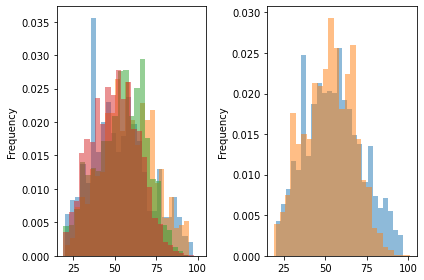

In [79]:
fig, (ax1,ax2) = plt.subplots(1,2,tight_layout=True)

ALL_data[(ALL_data['label']==1)&(ALL_data['性别']=='男')].年龄.plot.hist(stacked=True, bins=25, alpha=0.5,density=1,label = 'HTN',ax=ax1)
ALL_data[(ALL_data['label']==1)&(ALL_data['性别']=='女')].年龄.plot.hist(stacked=True, bins=25, alpha=0.5,density=1,label = 'HTN',ax=ax1)
ALL_data[(ALL_data['label']==0)&(ALL_data['性别']=='男')].年龄.plot.hist(stacked=True, bins=25, alpha=0.5,density=1,label = 'NHTN',ax=ax1)
ALL_data[(ALL_data['label']==0)&(ALL_data['性别']=='女')].年龄.plot.hist(stacked=True, bins=25, alpha=0.5,density=1,label = 'NHTN',ax=ax1)

ax2 = ALL_data[ALL_data['label']==1].年龄.plot.hist(stacked=True, bins=25, alpha=0.5,density=1,label = 'HTN',ax=ax2)
ax2 = ALL_data[ALL_data['label']==0].年龄.plot.hist(stacked=True, bins=25, alpha=0.5,density=1,label = 'NHTN',ax=ax2)

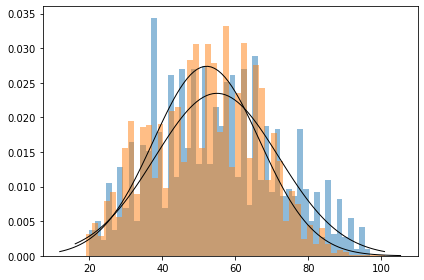

In [62]:
from scipy.stats import norm

fig, ax = plt.subplots(tight_layout=True)
n_bins = 50

data = ALL_data[ALL_data['label']==1]['年龄'].to_numpy()
# 拟合数据的正态分布参数: mu, std
mu, std = norm.fit (data)
ax.hist (data, n_bins, density=True,alpha = 0.5)
# 计算并绘制概率密度函数
xmin, xmax = plt.xlim ()
x = np.linspace (xmin, xmax, 100)
p = norm.pdf (x, mu, std)
ax.plot (x,p,'k',linewidth=1)

data = ALL_data[ALL_data['label']==0]['年龄'].to_numpy()
# 拟合数据的正态分布参数: mu, std
mu, std = norm.fit (data)
ax.hist (data, n_bins, density=True,alpha = 0.5)
# 计算并绘制概率密度函数
xmin, xmax = plt.xlim ()
x = np.linspace (xmin, xmax, 100)
p = norm.pdf (x, mu, std)
ax.plot (x,p,'k',linewidth=1)



plt.show()

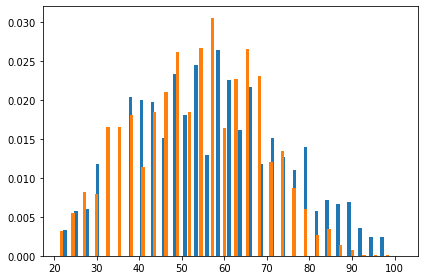

In [92]:
from scipy.stats import norm

fig, ax = plt.subplots(tight_layout=True)
n_bins = 50

data = ALL_data[ALL_data['label']==1]['年龄'].to_numpy()

y1,x1 = np.histogram(data,bins=30,density =True)
ax.bar(x1[1:],y1)

data = ALL_data[ALL_data['label']==0]['年龄'].to_numpy()
y2,x2 = np.histogram(data,bins=30,density =True)
ax.bar(x2[1:],y2,align='center')

# # 拟合数据的正态分布参数: mu, std
# mu, std = norm.fit (data)
# # 计算并绘制概率密度函数
# xmin, xmax = plt.xlim ()
# x = np.linspace (xmin, xmax, 100)
# p = norm.pdf (x, mu, std)
# ax.plot (x,p,'k',linewidth=1)





plt.show()